In [6]:
import os
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [60]:
def viz_single_session(eid, target, model, n_clus=8, n_neighbors=5):
    path = res_dir/eid/target/model/f'comp_-1.npy'
    gt = np.load(path, allow_pickle=True).item()['target']
    pred = np.load(path, allow_pickle=True).item()['pred']
    r2 = r2_score(gt.flatten(), pred.flatten())
    
    y = gt - gt.mean(0)
    y_pred = pred - pred.mean(0)
    y_resid = y - y_pred

    clustering = SpectralClustering(n_clusters=n_clus, n_neighbors=n_neighbors,
                                        affinity='nearest_neighbors',
                                        assign_labels='discretize',
                                        random_state=0)

    clustering = clustering.fit(y_pred)
    t_sort = np.argsort(clustering.labels_)
    
    vmin_perc, vmax_perc = 10, 90 
    vmax = np.percentile(y_pred, vmax_perc)
    vmin = np.percentile(y_pred, vmin_perc)
    
    toshow = [y, y_pred, y_resid]
    resid_vmax = np.percentile(toshow, vmax_perc)
    resid_vmin = np.percentile(toshow, vmin_perc)
    
    N = len(y)
    y_labels = [f'obs. {target}', f'pred. {target}', f'resid. {target}']

    fig, axes = plt.subplots(4, 1, figsize=(3, 6))
    # axes[0].plot(gt.mean(0),
    #         color=plt.get_cmap('tab10')(0),
    #         linewidth=3, alpha=0.3, label="target")
    # axes[0].plot(pred.mean(0),
    #         color = plt.get_cmap('tab10')(0), label="pred",
    #         linestyle='--')
    # axes[0].set_xlabel("time bin")
    
    im1 = axes[0].imshow(y[t_sort], aspect='auto', cmap='bwr', vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(im1, pad=0.02, shrink=.6)
    cbar.ax.tick_params(rotation=90)
    axes[0].set_title(f'{model} ({eid[:8]}) R2: {r2:.3f}')
    im2 = axes[1].imshow(y_pred[t_sort], aspect='auto', cmap='bwr', vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(im2, pad=0.02, shrink=.6)
    cbar.ax.tick_params(rotation=90)
    im3 = axes[2].imshow(y_resid[t_sort], aspect='auto', cmap='bwr', vmin=resid_vmin, vmax=resid_vmax)
    cbar = plt.colorbar(im3, pad=0.02, shrink=.6)
    cbar.ax.tick_params(rotation=90)
    
    for i, ax in enumerate(axes):
        # ax.set_ylabel(f"{y_labels[i]}"+f"\n(#trials={N})")
        ax.yaxis.set_ticks([])
        ax.yaxis.set_ticklabels([])
        ax.xaxis.set_ticks([])
        ax.xaxis.set_ticklabels([])
        ax.spines[['left','bottom', 'right', 'top']].set_visible(False)

    plt.tight_layout()
    
    plt.savefig(plot_dir/f'{target.split("_")[0]}_{eid[:5]}_{model}_r2_{r2:.3}.png')

In [3]:
res_dir = Path('/home/yizi/shared_decoding/results/pc_results')
plot_dir = Path('/home/yizi/shared_decoding/results/plots/residual_plots/')

eids = [
    '034e726f-b35f-41e0-8d6c-a22cc32391fb',
    '09b2c4d1-058d-4c84-9fd4-97530f85baf6',
    '0a018f12-ee06-4b11-97aa-bbbff5448e9f',
    '3537d970-f515-4786-853f-23de525e110f',
    '56b57c38-2699-4091-90a8-aba35103155e'
]

In [4]:
from sklearn.preprocessing import normalize, minmax_scale

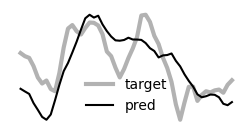

In [7]:
eid = '56b57c38-2699-4091-90a8-aba35103155e'
# eid = '09b2c4d1-058d-4c84-9fd4-97530f85baf6'
model = 'multi-sess-reduced-rank'
target = 'wheel_speed'

path = res_dir/eid/target/model/f'comp_-1.npy'
gt = np.load(path, allow_pickle=True).item()['target']
pred = np.load(path, allow_pickle=True).item()['pred']

gt = normalize(gt, axis=1)
pred = normalize(pred, axis=1)

fig, axes = plt.subplots(1, 1, figsize=(3, 1.5))
axes.plot(minmax_scale(gt.mean(0)),
        color='k',
        linewidth=3, alpha=0.3, label="target")
axes.plot(minmax_scale(pred.mean(0)),
        color = 'k', label="pred",
        linestyle='-')
axes.legend(frameon=False)
# axes.set_xticks([0, 10, 20, 30, 40, 50], [-0.2, 0, 0.2, 0.4, 0.6, 0.8])
axes.set_xticks([], [])
axes.set_yticks([], [])
# axes.set_xlabel("time (s)")
# axes.spines[['right', 'top']].set_visible(False)
axes.spines[['left', 'bottom', 'right', 'top']].set_visible(False)
# axes.legend(frameon=False);

# plt.savefig(plot_dir/f'{target}.png', dpi=200)

In [ ]:
for eid in eids:
    for target in ['motion_energy', 'wheel_speed', 'pupil_diameter']:
        # for model in ['ridge', 'reduced-rank', 'multi-sess-reduced-rank', 'mlp', 'lstm']:
        for model in ['multi-sess-reduced-rank']:
            viz_single_session(eid, target, model)
    #         break
    #     break
    # break

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import SpectralClustering
from sklearn.metrics import r2_score

In [39]:
"""
:X: [n_trials, n_timesteps, n_variables]
:y: [n_trials, n_timesteps] (in Hz)
:y_pred: [n_trials, n_timesteps] (in Hz)
:var_tasklist: for each task variable in var_tasklists, compute PSTH
:var_name2idx: for each task variable in var_tasklists, the corresponding index of X
:var_value2label:
:aligned_tbins: reference time steps to annotate. 
"""
def plot_psth(X, y, y_pred, var_tasklist, var_name2idx, var_value2label,
              aligned_tbins=[],
              axes=None, legend=False, neuron_idx=0):
    if axes is None:
        nrows = 1; ncols = len(var_tasklist)
        fig, axes = plt.subplots(nrows, ncols, figsize=(3 * ncols, 2 * nrows))

    for ci, var in enumerate(var_tasklist):
        ax = axes[ci]
        psth_xy = compute_all_psth(X, y, var_name2idx[var])
        psth_pred_xy = compute_all_psth(X, y_pred, var_name2idx[var])
        for _i, _x in enumerate(psth_xy.keys()):
            psth = psth_xy[_x]
            psth_pred = psth_pred_xy[_x]
            ax.plot(psth,
                    color=plt.get_cmap('tab10')(_i),
                    linewidth=3, alpha=0.3, label=f"{var_value2label[var][tuple(_x)]}")
            ax.plot(psth_pred,
                    color = plt.get_cmap('tab10')(_i),
                    linestyle='--')
            ax.set_xlabel("time (s)")
            ax.set_xticks([0, 40, 100], [-0.5, 0, 1.5])
            if ci == 0:
                ax.set_ylabel("Neural activity")
            else:
                ax.sharey(axes[0])
        _add_baseline(ax, aligned_tbins=aligned_tbins)
        if legend:
            ax.legend(frameon=False)
            ax.set_title(f"{var}")
    
    # compute PSTH for task_contingency
    idxs_psth = np.concatenate([var_name2idx[var] for var in var_tasklist])
    psth_xy = compute_all_psth(X, y, idxs_psth)
    psth_pred_xy = compute_all_psth(X, y_pred, idxs_psth)
    r2_psth = compute_R2_psth(psth_xy, psth_pred_xy)
    r2_single_trial = np.mean(compute_R2_main(y, y_pred, clip=False))
    '''
    axes[-1].annotate(f'PSTH R2: {r2_psth:.2f}'+"\n"+f"#conds: {len(psth_xy.keys())}", 
                        xy=(y.shape[1], 0), 
                        xytext=(y.shape[1]+20, 0), 
                        ha='left', 
                        rotation=90)
    '''
    axes[0].set_ylabel(f'{neuron_idx} \n trial-average R2: {r2_psth:.2f} \n single-trial R2: {r2_single_trial:.2f}')
    
    
    for ax in axes:
        # ax.axis('off')
        ax.spines[['right', 'top']].set_visible(False)
        # ax.set_frame_on(False)
        # ax.tick_params(bottom=False, left=False)
    plt.tight_layout()




"""
:X: [n_trials, n_timesteps, n_variables]
:y: [n_trials, n_timesteps] (in Hz)
:y_pred: [n_trials, n_timesteps] (in Hz)
:var_tasklist: variables used for computing the task-condition-averaged psth if subtract_psth=='task'
:var_name2idx:
:var_tasklist: variables to be plotted in the single-trial behavior
:subtract_psth: 
    - None: no subtraction
    - "task": subtract task-condition-averaged psth
    - "global": subtract global-averaged psth
:aligned_tbins: reference time steps to annotate. 
:nclus, n_neighbors: hyperparameters for spectral_clustering
:cmap, vmax_perc, vmin_perc: parameters used when plotting the activity and behavior
"""
def plot_single_trial_activity(X, y, y_pred,
                               var_name2idx,
                               var_behlist,
                               var_tasklist, subtract_psth="task",
                               aligned_tbins=[],
                               n_clus=8, n_neighbors=5, n_pc=32, clusby='y_pred',
                               cmap='bwr', vmax_perc=90, vmin_perc=10,
                               axes=None):
    if axes is None:
        ncols = 1; nrows = 2+len(var_behlist)+1+1
        fig, axes = plt.subplots(nrows, ncols, figsize=(8 * ncols, 3 * nrows))

    ### get the psth-subtracted y
    if subtract_psth is None:
        pass
    elif subtract_psth == "task":
        idxs_psth = np.concatenate([var_name2idx[var] for var in var_tasklist])
        psth_xy = compute_all_psth(X, y, idxs_psth)
        psth_pred_xy = compute_all_psth(X, y_pred, idxs_psth)
        y_psth = np.asarray(
            [psth_xy[tuple(x)] for x in X[:, 0, idxs_psth]])  # (K, T) predict the neural activity with psth
        y_predpsth = np.asarray(
            [psth_pred_xy[tuple(x)] for x in X[:, 0, idxs_psth]])  # (K, T) predict the neural activity with psth
        y = y - y_psth  # (K, T)
        y_pred = y_pred - y_predpsth  # (K, T)
    elif subtract_psth == "global":
        y_psth = np.mean(y, 0)
        y_predpsth = np.mean(y_pred, 0)
        y = y -y_psth  # (K, T)
        y_pred = y-y_predpsth  # (K, T)
    else:
        assert False, "Unknown subtract_psth, has to be one of: task, global. \'\'"
    y_residual = (y_pred - y)  # (K, T), residuals of prediction
    idxs_behavior = np.concatenate(([var_name2idx[var] for var in var_behlist])) if len(var_behlist)>0 else []
    X_behs = X[:, :, idxs_behavior]

    ### plot single-trial activity
    # arange the trials by unsupervised clustering labels
    # model = Rastermap(n_clusters=n_clus, # None turns off clustering and sorts single neurons 
    #               n_PCs=n_pc, # use fewer PCs than neurons
    #               locality=0.15, # some locality in sorting (this is a value from 0-1)
    #               time_lag_window=15, # use future timepoints to compute correlation
    #               grid_upsample=0, # 0 turns off upsampling since we're using single neurons
    #             )
    # if clusby == 'y_pred':
    #     clustering = model.fit(y_pred)
    # elif clusby == 'y':
    #     clustering = model.fit(y)
    # else:
    #     assert False, "invalid clusby"
    # t_sort = model.isort

    clustering = SpectralClustering(n_clusters=n_clus, n_neighbors=n_neighbors,
                                        affinity='nearest_neighbors',
                                        assign_labels='discretize',
                                        random_state=0)
    if clusby == 'y_pred':
        clustering = clustering.fit(y_pred)
    elif clusby == 'y':
        clustering = clustering.fit(y)
    else:
        assert False, "invalid clusby"
    t_sort = np.argsort(clustering.labels_)

    for ri, (toshow, label, ax) in enumerate(zip([y, y_pred, X_behs, y_residual],
                                                 [f"obs. behave. \n (subtract trial-average)",
                                                  f"pred. behave. \n (subtract trial-average)",
                                                  var_behlist,
                                                  "residual behave."],
                                                 [axes[0], axes[1], axes[2:-2], axes[-2]])):
        if ri <= 1:
            # plot obs./ predicted activity
            vmax = np.percentile(y_pred, vmax_perc)
            vmin = np.percentile(y_pred, vmin_perc)
            raster_plot(toshow[t_sort], vmax, vmin, True, label, ax,
                        cmap=cmap,
                        aligned_tbins=aligned_tbins)
        elif ri == 2:
            # plot behavior
            for bi in range(len(var_behlist)):
                ts_ = toshow[:, :, bi][t_sort]
                vmax = np.percentile(ts_, vmax_perc)
                vmin = np.percentile(ts_, vmin_perc)
                raster_plot(ts_, vmax, vmin, True, label[bi], ax[bi],
                            cmap=cmap,
                            aligned_tbins=aligned_tbins)
        elif ri == 3:
            # plot residual activity
            vmax = np.percentile(toshow, vmax_perc)
            vmin = np.percentile(toshow, vmin_perc)
            raster_plot(toshow[t_sort], vmax, vmin, True, label, ax,
                        cmap=cmap,
                        aligned_tbins=aligned_tbins)

    ### plot single-trial activity
    # re-arrange the trials
    clustering = SpectralClustering(n_clusters=n_clus,n_neighbors=n_neighbors,
                                    affinity='nearest_neighbors',
                                    assign_labels='discretize',
                                    random_state=0).fit(y_residual)
    t_sort_rd = np.argsort(clustering.labels_)
    # model = Rastermap(n_clusters=n_clus, n_PCs=n_pc, locality=0.15, time_lag_window=15, grid_upsample=0,).fit(y_residual)
    # t_sort_rd = model.isort
    raster_plot(y_residual[t_sort_rd], np.percentile(y_residual, vmax_perc), np.percentile(y_residual, vmin_perc), True, "residual behave. (re-clustered)", axes[-1])

    plt.tight_layout()


"""
This script generates a plot to examine the (single-trial) fitting of a single neuron.
:X: behavior matrix of the shape [n_trials, n_timesteps, n_variables]. 
:y: true neural activity matrix of the shape [n_trials, n_timesteps] 
:ypred: predicted activity matrix of the shape [n_trials, n_timesteps] 
:var_name2idx: dictionary mapping feature names to their corresponding index of the 3-rd axis of the behavior matrix X. e.g.: {"choice": [0], "wheel": [1]}
:var_tasklist: *static* task variables used to form the task condition and compute the psth. e.g.: ["choice"]
:var_value2label: dictionary mapping values in X to their corresponding readable labels (only required for static task variables). e.g.: {"choice": {1.: "left", -1.: "right"}}
:var_behlist: *dynamic* behavior variables. e.g., ["wheel"]
:subtract_psth: 
    - None: no subtraction
    - "task": subtract task-condition-averaged psth
    - "global": subtract global-averaged psth
:algined_tbins: reference time steps to annotate in the plot. 
"""


def viz_single_cell(X, y, y_pred, var_name2idx, var_tasklist, var_value2label, var_behlist,
                    subtract_psth="task", aligned_tbins=[], clusby='y_pred', neuron_idx=0):
    nrows = 8
    plt.figure(figsize=(8, 2 * nrows))

    ### plot psth
    axes_psth = [plt.subplot(nrows, len(var_tasklist), k+1) for k in range(len(var_tasklist))]
    plot_psth(X, y, y_pred,
              var_tasklist=var_tasklist,
              var_name2idx=var_name2idx,
              var_value2label=var_value2label,
              aligned_tbins=aligned_tbins,
              axes=axes_psth, legend=True, neuron_idx=neuron_idx)

    ### plot the psth-subtracted activity
    axes_single = [plt.subplot(nrows, 1, k) for k in range(2, 2 + 2 + len(var_behlist) + 2)]
    plot_single_trial_activity(X, y, y_pred,
                               var_name2idx,
                               var_behlist,
                               var_tasklist, subtract_psth=subtract_psth,
                               aligned_tbins=aligned_tbins,
                               clusby=clusby,
                               axes=axes_single)

    fig_name = 'single_neuron' + str(neuron_idx)
    plt.savefig(fig_name)
    plt.tight_layout();
    # plt.show()

In [9]:
def _add_baseline(ax, aligned_tbins=[40]):
    for tbin in aligned_tbins:
        ax.axvline(x=tbin-1, c='k', alpha=0.2)
    # ax.axhline(y=0., c='k', alpha=0.2)


def raster_plot(ts_, vmax, vmin, whether_cbar, ylabel, ax,
                cmap='bwr',
                aligned_tbins=[40]):
    N, T = ts_.shape
    im = ax.imshow(ts_, aspect='auto', cmap=cmap, vmax=vmax, vmin=vmin)
    for tbin in aligned_tbins:
        ax.annotate('',
            xy=(tbin-1, N),
            xytext=(tbin-1, N+10),
            ha='center',
            va='center',
            arrowprops={'arrowstyle': '->', 'color': 'r'})
    if whether_cbar:
        cbar = plt.colorbar(im, pad=0.01, shrink=.6)
        cbar.ax.tick_params(rotation=90)
    if not (ylabel is None):
        ax.set_ylabel(f"{ylabel}"+f"\n(#trials={N})")
        ax.yaxis.set_ticks([])
        ax.yaxis.set_ticklabels([])
        ax.xaxis.set_ticks([])
        ax.xaxis.set_ticklabels([])
        ax.spines[['left','bottom', 'right', 'top']].set_visible(False)
        pass
    else:
        ax.axis('off')

"""
- X, y should be nparray with
    - X: [K,T,ncoef]
    - y: [K,T,N] or [K,T]
- axis and value should be list
- return: nparray [T, N] or [T]
"""
def compute_PSTH(X, y, axis, value):
    trials = np.all(X[:, 0, axis] == value, axis=-1)
    return y[trials].mean(0)

def compute_all_psth(X, y, idxs_psth):
    uni_vs = np.unique(X[:, 0, idxs_psth], axis=0)  # get all the unique task-conditions
    psth_vs = {};
    for v in uni_vs:
        # compute separately for true y and predicted y
        _psth = compute_PSTH(X, y,
                                axis=idxs_psth, value=v)  # (T)
        psth_vs[tuple(v)] = _psth
    return psth_vs

"""
psth_xy/ psth_pred_xy: {tuple(x): (T) or (T,N)}
return a float or (N) array
"""
def compute_R2_psth(psth_xy, psth_pred_xy, clip=True):
    # compute r2 along dim 0
    r2s = [r2_score(psth_xy[x], psth_pred_xy[x], multioutput='raw_values') for x in psth_xy]
    if clip:
        r2s = np.clip(r2s,0.,1.)
    r2s = np.mean(r2s, 0)
    if len(r2s) == 1:
        r2s = r2s[0]
    return r2s



def compute_R2_main(y, y_pred, clip=True):
    """
    :y: (K, T, N) or (K*T, N)
    :y_pred: (K, T, N) or (K*T, N)
    """
    N = y.shape[-1]
    if len(y.shape) > 2:
        y = y.reshape((-1, N))
    if len(y_pred.shape) > 2:
        y_pred = y_pred.reshape((-1, N))
    r2s = np.asarray([r2_score(y[:, n].flatten(), y_pred[:, n].flatten()) for n in range(N)])
    if clip:
        return np.clip(r2s, 0., 1.)
    else:
        return r2s

In [10]:
import sys
from pathlib import Path
path_root = '/home/yizi/IBL_foundation_model/src'
sys.path.append(str(path_root))
from datasets import load_dataset, load_from_disk, concatenate_datasets
from loader.make_loader import make_loader

In [11]:
test_dataset = load_from_disk('/mnt/3TB/yizi/huggingface/decoding_datasets/56b57c38-2699-4091-90a8-aba35103155e')['test']

In [12]:
print(test_dataset)

Dataset({
    features: ['spikes_sparse_data', 'spikes_sparse_indices', 'spikes_sparse_indptr', 'spikes_sparse_shape', 'choice', 'reward', 'block', 'wheel-speed', 'left-whisker-motion-energy', 'left-pupil-diameter', 'binsize', 'interval_len', 'eid', 'probe_name', 'subject', 'lab', 'sampling_freq', 'cluster_regions', 'cluster_channels', 'good_clusters', 'cluster_depths', 'cluster_uuids'],
    num_rows: 96
})


In [13]:
# prepare the condition matrix
b_list = []

# choice
choice = np.array(test_dataset['choice'])
choice = np.tile(np.reshape(choice, (choice.shape[0], 1)), (1, 100))
b_list.append(choice)

# reward
reward = np.array(test_dataset['reward'])
reward = np.tile(np.reshape(reward, (reward.shape[0], 1)), (1, 100))
b_list.append(reward)

# block
block = np.array(test_dataset['block'])
block = np.tile(np.reshape(block, (block.shape[0], 1)), (1, 100))
b_list.append(block)

# wheel = np.array(test_dataset['wheel-speed'])
# b_list.append(wheel)

In [14]:
behavior_set = np.stack(b_list,axis=-1)
print(behavior_set.shape)

(96, 100, 3)


In [74]:
res_dir = Path('/mnt/3TB/yizi/ibl_fm/results')
# eid = '56b57c38-2699-4091-90a8-aba35103155e'
eid = '09b2c4d1-058d-4c84-9fd4-97530f85baf6'
# target = 'wheel-speed'
# target = 'left-whisker-motion-energy'
target = 'lightning-pose-left-pupil-diameter'
model = 'reduced-rank'

path = res_dir/target/model/f'{eid}.npy'
gt = np.load(path, allow_pickle=True).item()['test_y']
pred = np.load(path, allow_pickle=True).item()['test_pred']

In [75]:
# Settings for validation
X = behavior_set # [#trials, #timesteps, #variables]
ys = gt # [#trials, #timesteps, #neurons]
y_preds = pred # [#trials, #timesteps, #neurons]

var_name2idx = {'block':[2], 
                'choice': [0], 
                'reward': [1], 
                # 'wheel': [3],
                }

var_value2label = {'block': {(0.2,): "p(left)=0.2",
                            (0.5,): "p(left)=0.5",
                            (0.8,): "p(left)=0.8",},
                   'choice': {(-1.0,): "right",
                            (1.0,): "left"},
                   'reward': {(0.,): "no reward",
                            (1.,): "reward", } }

var_tasklist = ['block','choice','reward']
# var_behlist = ['wheel']
var_behlist = [] 

In [76]:
from sklearn.metrics import r2_score

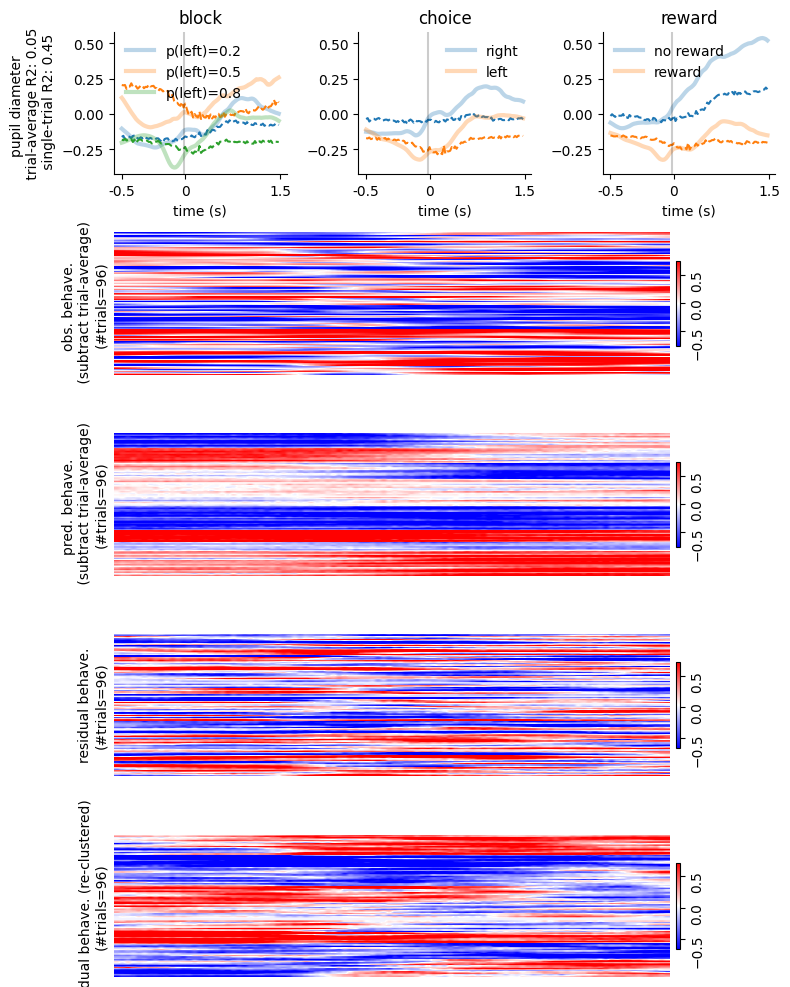

In [77]:
viz_single_cell(X, ys, y_preds, 
                var_name2idx, var_tasklist, var_value2label, var_behlist,
                subtract_psth="task", aligned_tbins=[40], neuron_idx='pupil diameter')
plt.savefig('../results/plots/resid_pupil_diameter.png', dpi=500)
plt.show()